In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import csv
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Summary

The required data is generated using MySQL and is named as question1.csv. Import this data for profiling loyal donors. <br>
The main features used in this notebook from question1.csv are: <br>
-  <b>PARTNER</b>: Id of donors.
-  <b>ZZAMNT_PAYED</b>: Donation paid by donors to a particular credit on a given date.
-  <b>ORDER_GUID</b>: Contains the id of the order line of the donation. <br>

ZZAMNT_PAYED doesn't take into account of joint donation. As in, both Donor A & Donor B donates 1000 Euro for Credit G, the data shows that Donor A donated 1000 Euro for Credit G and donor B donoated 1000 Euro for Credit G. <br>
This needs to be normalized, and that is done using the variable <b>ZZAMNT_PAYED_NORM</b>. <br>
Note that there are 3 types of credits that can be donated to the Leuven Univerity Fund (LUF), namely <b>Funds</b>, <b>Chairs</b>, & <b>Other Credits</b>. <br>
<br>

A loyal donor is a donor who has donated to Leuven University Fund (LUF) for atleast <b>5</b> times. <br>

As you will in this notebook, most of the loyal donors donate from Belgium. This doesn't mean they are of Belgian Nationality though. <br><br>

In this notebook, we profile the loyal donors based on their <b>age</b>, their <b>education background</b>, and <b>location</b>. <br>
For location profile, we will prepare the data in the required format and make an interactive plot using Tableau for Belgium based on number of loyal donors, donation sum, donation count, donation frequency. This plot is expected to assist the decision makers from the LUF for activities such as Campaigning. <br>

We also try to answer other key questions such as: <br>
-  Does the gift amount play a role for being a loyal donor?
-  Does a loyal donor always give the same amount?

In [3]:
question1 = pd.read_csv('sqldata/question1.csv',dtype = str)
question1 = question1[['PARTNER','ZZAMNT_PAYED','ORDER_GUID']]
print(question1.shape)
df = pd.DataFrame.from_dict(Counter((question1['ORDER_GUID'])), orient='index').reset_index()
df = df.rename(columns={'index':'ORDER_GUID', 0:'ORDER_GUID_COUNT'})
question1 = pd.merge(question1,df,on='ORDER_GUID',how='inner')
question1['ZZAMNT_PAYED'] = question1['ZZAMNT_PAYED'].astype('float64')
question1['ORDER_GUID_COUNT'] = question1['ORDER_GUID_COUNT'].astype('int32')
print(question1['ZZAMNT_PAYED'].sum())
question1['ZZAMNT_PAYED_NORM'] = question1['ZZAMNT_PAYED']/question1['ORDER_GUID_COUNT']
print(question1['ZZAMNT_PAYED_NORM'].sum())
question1.head()

(130934, 3)
138438337.52
130563906.12999998


,PARTNER,ZZAMNT_PAYED,ORDER_GUID,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
0,0200000002,1000.00,2294EB49A90B1ED5B8CC04B381270A59,1,1000.00
1,0200000002,1303.94,2294EB49A90B1ED5B8D00EC6A72B0A59,1,1303.94
2,0200000002,3000.00,2294EB49A90B1ED5B8CCE0FDE3458A59,1,3000.00
3,0200000002,2500.00,2294EB49A90B1ED5B8D00EB5A9094A59,1,2500.00
4,0200000002,2500.00,2294EB49A90B1ED5B8D00EB9C59C0A59,1,2500.00


In [4]:
#Check for inconsistency among the data. One inconsistency could be if the donation sum is less than 0
question1['ZZAMNT_PAYED'] = question1['ZZAMNT_PAYED'].astype('float64')
question1[question1['ZZAMNT_PAYED'] < 0]

,PARTNER,ZZAMNT_PAYED,ORDER_GUID,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
126029,0201222693,-675.0,2294EB49A90D1ED7A78F46F0734B400F,2,-337.5
126030,0201222694,-675.0,2294EB49A90D1ED7A78F46F0734B400F,2,-337.5


As you can see there are two entries where donation amount is -675 Euro. This is also a joint donation. This data needs to be removed.

In [5]:
question1 = question1[question1['ZZAMNT_PAYED'] >= 0]
question1.reset_index(drop=True,inplace=True)
print(question1['ZZAMNT_PAYED'].sum())
print(question1['ZZAMNT_PAYED_NORM'].sum())
print('Number of donors: '+str(len(set(question1['PARTNER']))))
print(question1.shape)
question1.head()

138439687.52
130564581.12999998
Number of donors: 56897
(130932, 5)


,PARTNER,ZZAMNT_PAYED,ORDER_GUID,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
0,0200000002,1000.00,2294EB49A90B1ED5B8CC04B381270A59,1,1000.00
1,0200000002,1303.94,2294EB49A90B1ED5B8D00EC6A72B0A59,1,1303.94
2,0200000002,3000.00,2294EB49A90B1ED5B8CCE0FDE3458A59,1,3000.00
3,0200000002,2500.00,2294EB49A90B1ED5B8D00EB5A9094A59,1,2500.00
4,0200000002,2500.00,2294EB49A90B1ED5B8D00EB9C59C0A59,1,2500.00


Without normalizing the donation sum, you see that the LUF received 138,439,687.52 Euro in total. <br>
After normaling the donation sum, you can see that the LUF actually received <b>130,564,581.13</b> Euro in total since 2002. <br>
LUF received 130,932 number of valid donations from 56,897 donors since 2002.

In the next couple of cells we calculate the statistics for each donors like: <br>
-  DONATION_COUNT: Number of times a donor has donated to LUF.
-  DONATION_MEAN: Mean donation sum of a donor.
-  DONATION_SUM: Total donation sum of a donor.
-  DONATION_CV: Coefficient of variation of donation sum. <br> 
etc

In [6]:
aggregate = pd.DataFrame(group.describe().rename(columns={'ZZAMNT_PAYED_NORM':name}).squeeze()
                         for name, group in question1[['PARTNER','ZZAMNT_PAYED_NORM']].groupby('PARTNER'))
aggregate['PARTNER'] = aggregate.index
aggregate = aggregate.reset_index(drop=True)
aggregate = aggregate.rename(columns={'count':'DONATION_COUNT',
                                      'mean':'DONATION_MEAN',
                                      'std':'DONATION_STD',
                                      'min':'DONATION_MIN',
                                      '25%':'DONATION_25',
                                      '50%':'DONATION_50',
                                      '75%':'DONATION_75',
                                      'max':'DONATION_MAX'})
                                      
front = aggregate['PARTNER']
aggregate.drop(labels=['PARTNER'], axis=1,inplace = True)
aggregate.insert(0, 'PARTNER', front)
aggregate.head()
aggregate.to_csv('aggregate.csv')

In [7]:
donor_amount_stats = aggregate
donor_amount_stats['DONATION_SUM'] = donor_amount_stats['DONATION_COUNT'] * donor_amount_stats['DONATION_MEAN']
donor_amount_stats['DONATION_CV'] = donor_amount_stats['DONATION_STD']/donor_amount_stats['DONATION_MEAN']
donor_amount_stats['DONATION_COUNT'] = donor_amount_stats['DONATION_COUNT'].astype(int)
print(donor_amount_stats.shape)
donor_amount_stats.head()

(56897, 11)


,PARTNER,DONATION_COUNT,DONATION_MEAN,DONATION_STD,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV
0,0200000002,7,2186.277143,735.028946,1000.0,1901.970,2500.0,2500.0,3000.00,15303.94,0.336201
1,0200000007,13,14058.253077,20169.415559,1250.0,4399.100,5750.0,11500.0,63563.29,182757.29,1.434703
2,0200000010,8,575.000000,265.921578,100.0,500.000,500.0,725.0,1000.00,4600.00,0.462472
3,0200000013,19,12567.816842,10158.236431,1000.0,3907.125,9110.0,24317.5,32000.00,238788.52,0.808274
4,0200000024,1,20000.000000,NaN,20000.0,20000.000,20000.0,20000.0,20000.00,20000.00,NaN


ADRC is a table that contains the address information of the business partners. <br>
BUT000 is a table that contains all the available information of the business partners like date of birth, sex, language, nationality, country, date of death etc. <br>
BUT020 is the links ADRC with BUT000. <br>
<img src="Images/Q1_table.png">

After merging these 3 tables, we'll get few more features that will help in profiling loyal donors such as:<br>
-  <b>ZZGEBOORTEJAAR</b>: Date of birth of the donors. This field has many missing/invalid values.
-  <b>TITLE_ACADEMDIC</b>: Contains the education profile of donors, if known. This field also has many missing values.
-  <b>TITLE</b>: Contains the title of donors.
-  <b>POST_CODE</b>: Contains the postal id location from where donation is carried out.
-  <b>COUNTRY</b>: Contains the country from where donation is carried out.

In [8]:
adrc = pd.read_csv('sqldata/20190102_ADRC.csv',dtype = str,sep=';')
adrc = adrc.rename(columns = {'POST_CODE1':'POST_CODE'})
adrc['POST_CODE'] = adrc['POST_CODE'].str.strip()#remove 'move down a line'(\r)
print(adrc.shape)
adrc.head()

(66150, 4)


,ADDRNUMBER,COUNTRY,DEFLT_COMM,POST_CODE
0,0007220702,BE,LET,8870
1,0007220705,BE,LET,3140
2,0007220708,BE,LET,3140
3,0007220711,BE,LET,8870
4,0007220713,BE,LET,8870


In [9]:
but000 = pd.read_csv('sqldata/20190102_BUT000.csv',dtype = str, encoding='latin-1',sep=';') 
but000_cols = ['PARTNER','ZZGEBOORTEJAAR','TYPE','BIRTHPL','BU_LANGU','NATIO','TITLE_ACA1','TITLE']
but000 = but000[but000_cols]
but000 = but000.rename(columns = {'TITLE_ACA1':'TITLE_ACADEMIC'})
print(but000.shape) #There are 72,114 different business partners in total. Among them there are 56,897 donors
but000.head()

(72114, 8)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE
0,0200000219,1960,1,Leuven,N,BE,NaN,0001
1,0200000424,1968,1,Bonheiden,N,BE,NaN,0001
2,0200000844,1962,1,Leuven,N,BE,NaN,0001
3,0200001162,1966,1,Lier,N,BE,NaN,0001
4,0200001323,1958,1,Kortrijk,N,BE,NaN,0002


In [10]:
but020 = pd.read_csv('sqldata/20190102_BUT020.csv',dtype = str,sep=';')
print(but020.shape)
but020.head()

(66150, 2)


,ADDRNUMBER,PARTNER
0,0007187199,0200257932
1,0007187202,0201054033
2,0007187205,0201054034
3,0007187207,0200058535
4,0007187210,0201054035


Below, we merge the profile of donors data with the aggregations of donation sum carried out before.

In [11]:
donor_temp = pd.merge((pd.merge(but000,but020,on='PARTNER',how='left')),
                      adrc,on='ADDRNUMBER',how='left')
q1_data = pd.merge(donor_temp,donor_amount_stats,on='PARTNER')
print(q1_data.shape)
q1_data.head()

(56897, 22)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_COUNT,DONATION_MEAN,DONATION_STD,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV
0,0200000219,1960,1,Leuven,N,BE,NaN,0001,0007985428,BE,...,1,20.0,NaN,20.0,20.0,20.0,20.0,20.0,20.0,NaN
1,0200000424,1968,1,Bonheiden,N,BE,NaN,0001,0000039287,BE,...,1,25.0,NaN,25.0,25.0,25.0,25.0,25.0,25.0,NaN
2,0200000844,1962,1,Leuven,N,BE,NaN,0001,0000040781,BE,...,1,15.0,NaN,15.0,15.0,15.0,15.0,15.0,15.0,NaN
3,0200001162,1966,1,Lier,N,BE,NaN,0001,0003251413,BE,...,1,50.0,NaN,50.0,50.0,50.0,50.0,50.0,50.0,NaN
4,0200002575,1966,1,Roeselare,N,BE,NaN,0001,0000046646,BE,...,1,100.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,NaN


In [12]:
donation_stat_cols = ['DONATION_COUNT','DONATION_MEAN','DONATION_STD','DONATION_MIN','DONATION_25','DONATION_50','DONATION_75',
                      'DONATION_MAX','DONATION_SUM','DONATION_CV']
q1_data[donation_stat_cols] = q1_data[donation_stat_cols].astype('float64')
q1_data['ZZGEBOORTEJAAR'] = q1_data['ZZGEBOORTEJAAR'].astype('int32')
q1_data['IS_LOYAL'] = np.where(q1_data['DONATION_COUNT']>=5, 1, 0)#see if the customer is loyal
q1_data['IS_LOYAL2'] = np.where(q1_data['DONATION_COUNT']>=2, 1, 0)#see if the customer is loyal
q1_data['IS_LOYAL10'] = np.where(q1_data['DONATION_COUNT']>=10, 1, 0)#see if the customer is loyal
print(q1_data.shape)
q1_data.head()

(56897, 25)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,IS_LOYAL,IS_LOYAL2,IS_LOYAL10
0,0200000219,1960,1,Leuven,N,BE,NaN,0001,0007985428,BE,...,20.0,20.0,20.0,20.0,20.0,20.0,NaN,0,0,0
1,0200000424,1968,1,Bonheiden,N,BE,NaN,0001,0000039287,BE,...,25.0,25.0,25.0,25.0,25.0,25.0,NaN,0,0,0
2,0200000844,1962,1,Leuven,N,BE,NaN,0001,0000040781,BE,...,15.0,15.0,15.0,15.0,15.0,15.0,NaN,0,0,0
3,0200001162,1966,1,Lier,N,BE,NaN,0001,0003251413,BE,...,50.0,50.0,50.0,50.0,50.0,50.0,NaN,0,0,0
4,0200002575,1966,1,Roeselare,N,BE,NaN,0001,0000046646,BE,...,100.0,100.0,100.0,100.0,100.0,100.0,NaN,0,0,0


In [13]:
from scipy.stats import shapiro #To check for normality
corr_cols = ['DONATION_COUNT','DONATION_MEAN','DONATION_MIN','DONATION_25','DONATION_50','DONATION_75',
             'DONATION_MAX','DONATION_SUM','DONATION_CV','IS_LOYAL2','IS_LOYAL','IS_LOYAL10']
corr_cal = q1_data[corr_cols]
cols = ['DONATION_COUNT','DONATION_MEAN','DONATION_50','DONATION_SUM','IS_LOYAL2','IS_LOYAL','IS_LOYAL10']
shapiro_test_cols = ['shapiro_stat','p_value']
shapiro_test_df = pd.DataFrame(columns = shapiro_test_cols)
for col in cols:
    shapiro_stat,p_value = shapiro(corr_cal[col])
    df = pd.DataFrame([[shapiro_stat,p_value]],columns = shapiro_test_cols,index=[col])
    shapiro_test_df = shapiro_test_df.append(df)

shapiro_test_df

,shapiro_stat,p_value
DONATION_COUNT,0.171580,0.0
DONATION_MEAN,0.058024,0.0
DONATION_50,0.056158,0.0
DONATION_SUM,0.019403,0.0
IS_LOYAL2,0.545830,0.0
IS_LOYAL,0.303760,0.0
IS_LOYAL10,0.173476,0.0


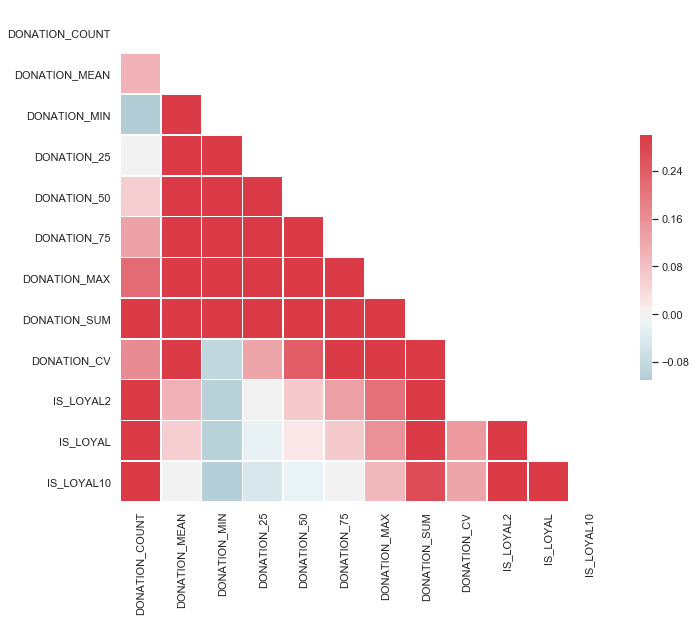

In [14]:
def plot_correlation_heatmap(df):
    corr = df.corr(method='spearman')  #Spearman correlation is used as shapiro test (below) shows data is not normal
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(corr_cal)#only features (X)

In [15]:
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr
print(spearmanr(corr_cal['DONATION_MEAN'],corr_cal['IS_LOYAL']))
#print(pearsonr(corr_cal['DONATION_MEAN'],corr_cal['IS_LOYAL']))
cols = ['DONATION_MEAN','DONATION_MIN','DONATION_25','DONATION_50','DONATION_75','DONATION_MAX','DONATION_SUM']
spearman_cor_cols = ['IS_LOYAL','P-Value']
spearman_cor_df = pd.DataFrame(columns = spearman_cor_cols)
for col in cols:
    spear_col_stat,p_value = spearmanr(corr_cal[col],corr_cal['IS_LOYAL'])
    df = pd.DataFrame([[spear_col_stat,p_value]],columns=spearman_cor_cols,index=[col])
    spearman_cor_df = spearman_cor_df.append(df)
    
spearman_cor_df['IS_LOYAL'] = spearman_cor_df['IS_LOYAL'].round(4)    
spearman_cor_df

SpearmanrResult(correlation=0.060221937967948634, pvalue=7.160660947838633e-47)


,IS_LOYAL,P-Value
DONATION_MEAN,0.0602,7.160661e-47
DONATION_MIN,-0.0994,6.288030e-125
DONATION_25,-0.0217,2.230638e-07
DONATION_50,0.0207,7.457549e-07
DONATION_75,0.0638,2.197302e-52
DONATION_MAX,0.1552,1.253950e-303
DONATION_SUM,0.3968,0.000000e+00


The above 2 cells is used to answer the question: Does the gift amount play a role for being a loyal donor? <br>
We found the answer to be <b>No</b> as no significant correlation between being a loyal donor & donation statistics such as mean/sum/min etc.

## Loyal Donors
From now onwards we will analyse the profile that is specific to loyal donors. <br>
A loyal donor is someone who has donated to LUF at least 5 times.

In [16]:
loyal_donor = q1_data[q1_data['DONATION_COUNT']>=5]
print(loyal_donor.shape)
loyal_donor.head()

(4640, 25)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,IS_LOYAL,IS_LOYAL2,IS_LOYAL10
6,0200003499,1941,1,Dendermonde,N,BE,0003,0002,0000049649,BE,...,25.0,30.00,40.0,50.0,125.0,270.0,0.756204,1,1,0
7,0200005037,1967,1,Dendermonde,N,BE,NaN,0001,0001045864,BE,...,20.0,25.00,50.0,100.0,160.0,580.0,0.797332,1,1,0
8,0200005221,1941,1,Brugge,N,BE,0003,0002,0000055278,BE,...,15.0,17.50,20.0,30.0,60.0,190.0,0.618841,1,1,0
9,0200006547,1943,1,Aalst,N,BE,0008,0002,0007681446,BE,...,30.0,63.75,137.5,275.0,500.0,2440.0,0.776334,1,1,1
13,0200015505,1950,1,Tienen,N,BE,NaN,0002,0008926470,BE,...,50.0,50.00,1000.0,1000.0,1000.0,5150.0,0.763762,1,1,0


Check the missing values in the data and fill the missing values with appropriate labels

In [17]:
loyal_donor.isna().sum()

PARTNER              0
ZZGEBOORTEJAAR       0
TYPE                 0
BIRTHPL           3601
BU_LANGU          3045
NATIO             3035
TITLE_ACADEMIC    4078
TITLE              521
ADDRNUMBER           2
COUNTRY              2
DEFLT_COMM           9
POST_CODE            9
DONATION_COUNT       0
DONATION_MEAN        0
DONATION_STD         0
DONATION_MIN         0
DONATION_25          0
DONATION_50          0
DONATION_75          0
DONATION_MAX         0
DONATION_SUM         0
DONATION_CV          0
IS_LOYAL             0
IS_LOYAL2            0
IS_LOYAL10           0
dtype: int64

In [18]:
loyal_donor['BIRTHPL'] = loyal_donor['BIRTHPL'].fillna('Unknown')
loyal_donor['BU_LANGU'] = loyal_donor['BU_LANGU'].fillna('Unknown')
loyal_donor['NATIO'] = loyal_donor['NATIO'].fillna('Unknown')
loyal_donor['TITLE_ACADEMIC'] = loyal_donor['TITLE_ACADEMIC'].fillna('Unknown')
loyal_donor['TITLE'] = loyal_donor['TITLE'].fillna('Unknown')
print(loyal_donor.shape)
loyal_donor.head()

(4640, 25)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,IS_LOYAL,IS_LOYAL2,IS_LOYAL10
6,0200003499,1941,1,Dendermonde,N,BE,0003,0002,0000049649,BE,...,25.0,30.00,40.0,50.0,125.0,270.0,0.756204,1,1,0
7,0200005037,1967,1,Dendermonde,N,BE,Unknown,0001,0001045864,BE,...,20.0,25.00,50.0,100.0,160.0,580.0,0.797332,1,1,0
8,0200005221,1941,1,Brugge,N,BE,0003,0002,0000055278,BE,...,15.0,17.50,20.0,30.0,60.0,190.0,0.618841,1,1,0
9,0200006547,1943,1,Aalst,N,BE,0008,0002,0007681446,BE,...,30.0,63.75,137.5,275.0,500.0,2440.0,0.776334,1,1,1
13,0200015505,1950,1,Tienen,N,BE,Unknown,0002,0008926470,BE,...,50.0,50.00,1000.0,1000.0,1000.0,5150.0,0.763762,1,1,0


### Age Profile

In [19]:
loyal_donor['AGE'] = 2019 - loyal_donor['ZZGEBOORTEJAAR']  
cut_points = [0,10,20,30,40,50,60,70,80,90,100,loyal_donor["AGE"].max()]
age_cat_names = ["0-10", "10-20", "20-30", "30-40", "40-50","50-60","60-70","70-80","80-90","90-100","Unknown"]
loyal_donor["AGE_CATEGORY"] = pd.cut(loyal_donor["AGE"],cut_points,labels=age_cat_names)
print(loyal_donor.shape)
loyal_donor.head()

(4640, 27)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,IS_LOYAL,IS_LOYAL2,IS_LOYAL10,AGE,AGE_CATEGORY
6,0200003499,1941,1,Dendermonde,N,BE,0003,0002,0000049649,BE,...,40.0,50.0,125.0,270.0,0.756204,1,1,0,78,70-80
7,0200005037,1967,1,Dendermonde,N,BE,Unknown,0001,0001045864,BE,...,50.0,100.0,160.0,580.0,0.797332,1,1,0,52,50-60
8,0200005221,1941,1,Brugge,N,BE,0003,0002,0000055278,BE,...,20.0,30.0,60.0,190.0,0.618841,1,1,0,78,70-80
9,0200006547,1943,1,Aalst,N,BE,0008,0002,0007681446,BE,...,137.5,275.0,500.0,2440.0,0.776334,1,1,1,76,70-80
13,0200015505,1950,1,Tienen,N,BE,Unknown,0002,0008926470,BE,...,1000.0,1000.0,1000.0,5150.0,0.763762,1,1,0,69,60-70


Text(0.5, 1.0, 'Age profile of loyal donors')

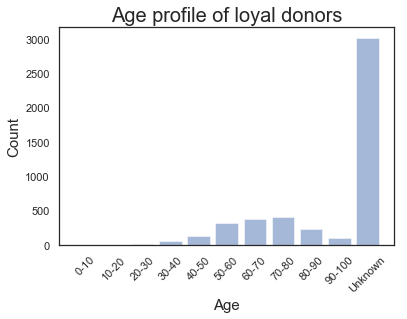

In [20]:
plt.bar(age_cat_names, loyal_donor['AGE_CATEGORY'].value_counts(sort=False), align='center', alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Age',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Age profile of loyal donors',fontsize=20)

Clearly majority of the Age data is missing. <br>
But among the data that is available it can be seen people who are older than 50+ years tend to be a loyal donor.

### Title Profile

Text(0.5, 1.0, 'Titles of loyal donors')

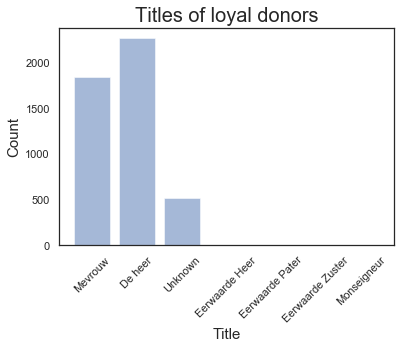

In [21]:
titles=['Mevrouw','De heer','Unknown','Eerwaarde Heer','Eerwaarde Pater','Eerwaarde Zuster','Monseigneur']
loyal_donor['TITLE'].value_counts().sort_index()
plt.bar(titles, loyal_donor['TITLE'].value_counts().sort_index(), align='center', alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Title',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Titles of loyal donors',fontsize=20)

From the data that is available, it can be seen that there are slightly more loyal donors who are men (De heer) than woman (Mevrouw).

### Education Profile

Text(0.5, 1.0, 'Education/Background profile of loyal donors')

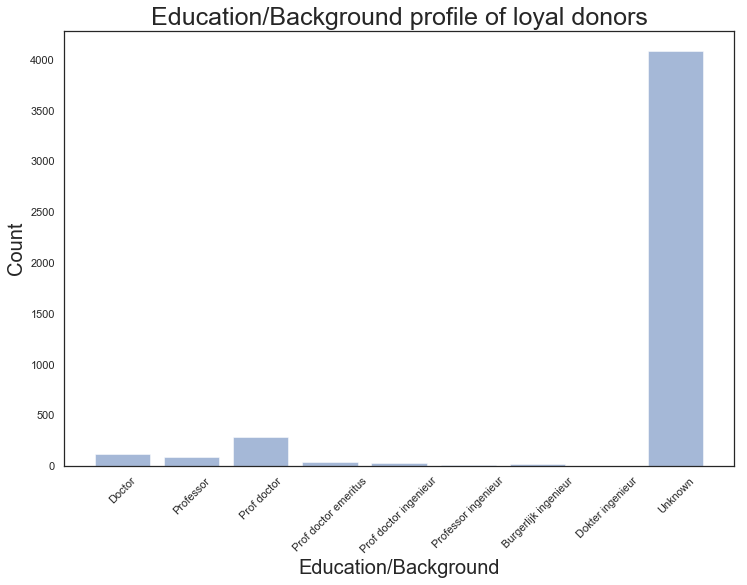

In [22]:
fig = plt.figure(figsize = (12,8))
academic_titles = ['Doctor','Professor','Prof doctor','Prof doctor emeritus','Prof doctor ingenieur','Professor ingenieur','Burgerlijk ingenieur','Dokter ingenieur','Unknown']
loyal_donor['TITLE_ACADEMIC'].value_counts().sort_index()
plt.bar(academic_titles, loyal_donor['TITLE_ACADEMIC'].value_counts().sort_index(), align='center', alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Education/Background',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.title('Education/Background profile of loyal donors',fontsize=25)

A proper conclusion could not be drawn about the education profile of loyal donors due to the amount of missing data. <br>

The below cell tries to answer the question: Does a loyal donor always give the same amount?

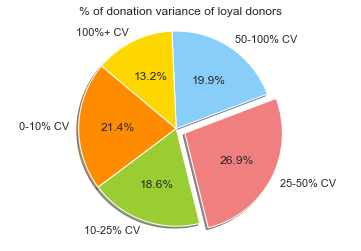

In [23]:
labels = ['0-10% CV','10-25% CV','25-50% CV','50-100% CV','100%+ CV']
donation_cv = loyal_donor['DONATION_CV']
ranges = [0,0.10,0.25,0.50,1,10]
sizes = donation_cv.value_counts(bins=ranges,sort=False)
colors = ['darkorange', 'yellowgreen', 'lightcoral', 'lightskyblue','gold']
explode = np.where(sizes==sizes.max(), 0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('% of donation variance of loyal donors')
plt.axis('equal')
plt.show()

Most of the donors usually donate similar amount. As most of them have moderate Coefficient of Variation (CV).

## Location Profile

#### Location Profile - Country

In [24]:
ld = loyal_donor
ld['DONATION_COUNT'] = ld['DONATION_COUNT'].astype('int32')
column_names = ['Region','No_of_Loyal_Donors','Donation_Count','Avg_Donation_Freq','Total_Donation','Avg_Donation']
donation_stats = pd.DataFrame(columns = column_names)
for reg,count in ld['COUNTRY'].value_counts().iteritems():
    donation_stats.loc[len(donation_stats)] = [reg,format(count,",d"),format(ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum(),",d"),format(ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum()/count,",.2f"),format(round(ld[ld['COUNTRY'] == reg]['DONATION_SUM'].sum(),2),",.2f"),format(round(ld[ld['COUNTRY'] == reg]['DONATION_SUM'].sum()/ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum(),2),",.2f")]
    #print(reg,count,ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum(),ld[ld['COUNTRY'] == reg]['DONATION_SUM'].sum(),ld[ld['COUNTRY'] == reg]['DONATION_SUM'].sum()/ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum())

donation_stats.loc[len(donation_stats)] = ['Outside BE',format(ld[ld['COUNTRY'] != 'BE']['COUNTRY'].size,",d"),format(ld[ld['COUNTRY'] != 'BE']['DONATION_COUNT'].sum(),",d"),format(ld[ld['COUNTRY'] != 'BE']['DONATION_COUNT'].sum()/ld[ld['COUNTRY'] != 'BE']['COUNTRY'].size,",.2f"),format(round(ld[ld['COUNTRY'] != 'BE']['DONATION_SUM'].sum(),2),",.2f"),format(round(ld[ld['COUNTRY'] != 'BE']['DONATION_SUM'].sum()/ld[ld['COUNTRY'] != 'BE']['DONATION_COUNT'].sum(),2),",.2f")]
#put the last row ('Outside BE') to first row
donation_stats = donation_stats.apply(np.roll, shift=1)
#swap the first two rows ('Outside BE' & 'BE')
b, c = donation_stats.iloc[0], donation_stats.iloc[1]
temp = donation_stats.iloc[0].copy()
donation_stats.iloc[0] = c
donation_stats.iloc[1] = temp
donation_stats

,Region,No_of_Loyal_Donors,Donation_Count,Avg_Donation_Freq,Total_Donation,Avg_Donation
0,BE,"4,587","62,717",13.67,"83,025,409.56","1,323.81"
1,Outside BE,53,831,15.68,"16,141,546.81","19,424.24"
2,NL,26,428,16.46,"10,283,103.98","24,025.94"
3,CH,10,203,20.30,"3,808,218.46","18,759.70"
4,DE,4,59,14.75,"485,510.00","8,228.98"
5,LU,3,38,12.67,"5,490.00",144.47
6,US,3,39,13.00,"1,546,084.37","39,643.19"
7,GR,2,10,5.00,370.00,37.00
8,FR,2,10,5.00,290.00,29.00
9,SE,1,6,6.00,855.00,142.50


Not surprisingly, Belgium (BE) tops the list with the highest number of loyal donors, the highest number of donations received, and the total donation sum received. <br>
An interesting observation from the table is that loyal donors from Switzerland (CH) donate more frequently (Avg_Donation_Freq) to LUF than any other country. Meaning that a loyal donor from Switzerland donates to LUF on an average of 20.30 times. <br>
Another interesting observation from the table is that loyal donors from United States (US) tend to give more money per donation to LUF than any other country. As in, there are only 3 loyal donors from United States and each time they donate to LUF, they give an average of 39,683.19 Euro to LUF.

In [25]:
country = loyal_donor['COUNTRY'].value_counts()
country['BE']/country.sum()

0.9890038809831824

About 99% of the loyal donors donate from Belgium

In [26]:
def province (be):
    if 1000 <= be['POST_CODE'] <= 1299 :
        return'Brussels' 
    if 1300 <= be['POST_CODE'] <= 1499 :
        return 'Walloon Brabant'
    if 1500 <= be['POST_CODE'] <= 1999 :
        return 'Flemish Brabant'
    if 2000 <= be['POST_CODE'] <= 2999 :
        return 'Antwerp'
    if 3000 <= be['POST_CODE'] <= 3499 :
        return 'Flemish Brabant'
    if 3500 <= be['POST_CODE'] <= 3999 :
        return 'Limburg'
    if 4000 <= be['POST_CODE'] <= 4999 :
        return 'Liege'
    if 5000 <= be['POST_CODE'] <= 5999 :
        return 'Namur'
    if 6000 <= be['POST_CODE'] <= 6599 :
        return 'Hainaut'
    if 6600 <= be['POST_CODE'] <= 6999 :
        return 'Luxembourg'
    if 7000 <= be['POST_CODE'] <= 7999 :
        return 'Hainaut'
    if 8000 <= be['POST_CODE'] <= 8999 :
        return 'West Flanders'
    if 9000 <= be['POST_CODE'] <= 9999 :
        return 'East Flanders'
    return 'Unknown'

be_loyal_donor = loyal_donor[loyal_donor['COUNTRY']=='BE']
be_loyal_donor['POST_CODE'] = be_loyal_donor['POST_CODE'].fillna(3000)
be_loyal_donor['POST_CODE'] = be_loyal_donor['POST_CODE'].astype('int32')
be_loyal_donor['DONATION_COUNT'] = be_loyal_donor['DONATION_COUNT'].astype('int32')
be_loyal_donor['PROVINCE'] = be_loyal_donor.apply(province,axis=1)

In [27]:
be_loc_vis_cols = ['PARTNER','POST_CODE','COUNTRY','PROVINCE','DONATION_COUNT','DONATION_MEAN','DONATION_STD','DONATION_MIN','DONATION_25',
                'DONATION_50','DONATION_75','DONATION_MAX','DONATION_SUM','DONATION_CV']
be_visualization_data = be_loyal_donor[be_loc_vis_cols]
print(be_visualization_data.shape)
city = pd.read_csv('ZIP_CITY_BE.csv', encoding='latin-1')
be_visualization_data = pd.merge(be_visualization_data,city,on='POST_CODE',how='inner')
print(be_visualization_data.shape)
be_visualization_data.head()

(4587, 14)
(4587, 15)


,PARTNER,POST_CODE,COUNTRY,PROVINCE,DONATION_COUNT,DONATION_MEAN,DONATION_STD,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,CITY
0,0200003499,3360,BE,Flemish Brabant,5,54.000000,40.835034,25.0,30.0,40.0,50.0,125.0,270.0,0.756204,Bierbeek
1,0200279709,3360,BE,Flemish Brabant,10,72.000000,38.239014,30.0,50.0,50.0,100.0,150.0,720.0,0.531097,Bierbeek
2,0200002775,3360,BE,Flemish Brabant,7,116.428571,90.678658,50.0,75.0,100.0,100.0,315.0,815.0,0.778835,Bierbeek
3,0200006395,3360,BE,Flemish Brabant,159,40.166667,52.000994,7.5,7.5,15.0,50.0,250.0,6386.5,1.294631,Bierbeek
4,0200013673,3360,BE,Flemish Brabant,11,284.545455,166.214538,50.0,175.0,250.0,440.0,500.0,3130.0,0.584141,Bierbeek


#### Location Profile - Province (Belgium)

In [28]:
bld = be_visualization_data
bep_column_names = ['Province','No_of_Loyal_Donors','Donation_Count','Avg_Donation_Freq','Total_Donation','Avg_Donation']
bep_donation_stats = pd.DataFrame(columns = bep_column_names)
for prov,count in bld['PROVINCE'].value_counts().iteritems():
    bep_donation_stats.loc[len(bep_donation_stats)] = [prov,format(count,",d"),format(bld[bld['PROVINCE'] == prov]['DONATION_COUNT'].sum(),",d"),format(bld[bld['PROVINCE'] == prov]['DONATION_COUNT'].sum()/count,",.2f"),format(round(bld[bld['PROVINCE'] == prov]['DONATION_SUM'].sum(),2),",.2f"),format(round(bld[bld['PROVINCE'] == prov]['DONATION_SUM'].sum()/bld[bld['PROVINCE'] == prov]['DONATION_COUNT'].sum(),2),",.2f")]
bep_donation_stats 

,Province,No_of_Loyal_Donors,Donation_Count,Avg_Donation_Freq,Total_Donation,Avg_Donation
0,Flemish Brabant,"2,103","29,564",14.06,"29,684,303.75","1,004.07"
1,Antwerp,853,"12,461",14.61,"16,646,103.08","1,335.86"
2,West Flanders,525,"6,176",11.76,"2,900,748.24",469.68
3,East Flanders,518,"6,140",11.85,"3,577,895.16",582.72
4,Limburg,386,"4,985",12.91,"1,264,598.62",253.68
5,Brussels,152,"2,680",17.63,"25,584,981.65","9,546.63"
6,Walloon Brabant,27,478,17.70,"3,220,414.22","6,737.27"
7,Liege,15,166,11.07,"18,419.84",110.96
8,Hainaut,5,30,6.00,"124,750.00","4,158.33"
9,Luxembourg,2,32,16.00,595.00,18.59


As expected <b>Flemish Brabant</b> province clearly tops the list with the highest number of loyal donors, the highest number of donations received, and the total donation sum received. <br>
Quite surprisingly, the province of <b>Wallon Brabant</b> has the highest Avg_Donation_Freq of 17.70 means that a loyal donor from Wallonia donates to LUF on an average of 17.70 times. <br>
Not so surprisingly, <b>Brussels</b> province has the highest Avg_Donation of 9,566.63 Euro means that when a loyal donor from Brussels donates to LUF, on an average they donate an amount of 9,566.63 Euro which is pretty high. That is the reason why Brussels has the second highest Total_Donation even though it has the sixth highest No_of_Loyal_Donors.

#### Location Profile - Postal (Top 10 from Belgium)

In [29]:
bez_column_names = ['Zip_Code','City/Town','Province','No_of_Loyal_Donors','Donation_Count','Avg_Donation_Freq','Total_Donation','Avg_Donation']
bez_donation_stats = pd.DataFrame(columns = bez_column_names)
for zipc,count in bld['POST_CODE'].value_counts().iteritems():
    bez_donation_stats.loc[len(bez_donation_stats)] = [zipc,''.join(bld[bld['POST_CODE']==zipc]['CITY'][:1].values),''.join(bld[bld['POST_CODE']==zipc]['PROVINCE'][:1].values),format(count,",d"),format(bld[bld['POST_CODE'] == zipc]['DONATION_COUNT'].sum(),",d"),format(bld[bld['POST_CODE'] == zipc]['DONATION_COUNT'].sum()/count,",.2f"),format(round(bld[bld['POST_CODE'] == zipc]['DONATION_SUM'].sum(),2),",.2f"),format(round(bld[bld['POST_CODE'] == zipc]['DONATION_SUM'].sum()/bld[bld['POST_CODE'] == zipc]['DONATION_COUNT'].sum(),2),",.2f")]
bez_donation_stats[:10]#Sorted in descending order according to No_of_Loyal_Donors

,Zip_Code,City/Town,Province,No_of_Loyal_Donors,Donation_Count,Avg_Donation_Freq,Total_Donation,Avg_Donation
0,3000,Leuven,Flemish Brabant,309,"5,483",17.74,"13,157,638.68","2,399.72"
1,3001,Heverlee,Flemish Brabant,217,"2,770",12.76,"1,429,463.14",516.05
2,3010,Kessel Lo,Flemish Brabant,168,"2,834",16.87,"893,779.70",315.38
3,3020,Herent,Flemish Brabant,151,"1,742",11.54,"370,152.33",212.49
4,3210,Lubbeek,Flemish Brabant,69,712,10.32,"645,210.91",906.20
5,2800,Mechelen,Antwerp,63,921,14.62,"2,067,259.61","2,244.58"
6,3500,Hasselt,Limburg,61,"1,022",16.75,"314,815.50",308.04
7,3060,Bertem,Flemish Brabant,48,818,17.04,"68,897.00",84.23
8,3012,Wilsele,Flemish Brabant,47,616,13.11,"47,225.06",76.66
9,9000,Gent,East Flanders,47,452,9.62,"2,032,567.37","4,496.83"


Only the top 10 results are displayed. <br>
Not surprisingly the top 5 postal codes for the no of loyal donors are around the city of Leuven. (3000, 3001, 3010, 3020, & 3210) <br>

To get a complete idea about the donations from all postal codes from Belgium, checks the Tableau Visualization from the links below.

## Tableau Visualization

In [30]:
be_visualization_data.to_csv('sqldata/BE_Loyal_Donor_Visualization.csv')
print(be_visualization_data.shape)
be_visualization_data.head()

(4587, 15)


,PARTNER,POST_CODE,COUNTRY,PROVINCE,DONATION_COUNT,DONATION_MEAN,DONATION_STD,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,CITY
0,0200003499,3360,BE,Flemish Brabant,5,54.000000,40.835034,25.0,30.0,40.0,50.0,125.0,270.0,0.756204,Bierbeek
1,0200279709,3360,BE,Flemish Brabant,10,72.000000,38.239014,30.0,50.0,50.0,100.0,150.0,720.0,0.531097,Bierbeek
2,0200002775,3360,BE,Flemish Brabant,7,116.428571,90.678658,50.0,75.0,100.0,100.0,315.0,815.0,0.778835,Bierbeek
3,0200006395,3360,BE,Flemish Brabant,159,40.166667,52.000994,7.5,7.5,15.0,50.0,250.0,6386.5,1.294631,Bierbeek
4,0200013673,3360,BE,Flemish Brabant,11,284.545455,166.214538,50.0,175.0,250.0,440.0,500.0,3130.0,0.584141,Bierbeek


BE_Loyal_Donor_Visualization.csv is used as an input to make an interactive loyal donor location plot for Belgium. <br>
This file is used along with the postal to municipality, sub-municiplaity, and province mapping of Belgium for the plot. <br>
This data is stored in the file: 'Provincie - gemeente - deelgemeente - postcode.csv'. <br>
Gemeente means Municipality. <br>
Deelgemeente means Sub-municipality.

In [31]:
be_map = pd.read_csv('sqldata\Provincie - gemeente - deelgemeente - postcode.csv', encoding='latin-1')
print(be_map.shape)
be_map.head()

(1018, 4)


,postcode,gemeente,deelgemeente,provincie
0,1000,Brussel,Brussel,Brussels Hoofdstedelijk Gewest
1,1020,Brussel,Laeken,Brussels Hoofdstedelijk Gewest
2,1030,Schaarbeek,Schaarbeek,Brussels Hoofdstedelijk Gewest
3,1040,Brussel,Brussel,Brussels Hoofdstedelijk Gewest
4,1050,Brussel,Brussel,Brussels Hoofdstedelijk Gewest


5 differents Tableau visualizations are made based on: <br>
-  Based on <b>Number of Loyal Donors</b>
-  Based on <b>Donation Count</b>
-  Based on <b>Average Donation Frequency</b>
-  Based on <b>Total Donation</b>
-  Based on <b>Average Donation</b>

The tableau plot below shows the spread of loyeal donors according to Average Donation: <br><br>
<b>Province Level</b>
<img src="Images/Q1_tableau_province_level_avg_donation.png">
Clearly <b>Brussels</b> is the province that has the highest average donation per donor to LUF with an average donation of <b>9,547</b> Euro. <br>

The plot also shows how Belgium is divided! Since KU Leuven is a flemish university, most of the loyal donors of Belgium are from the flemish region. The loyal donors from wallonia region are a minority.

<b>Gemeente</b><br>
Let's zoom in and look at the municipality level. <br>
<img src="Images/Q1_tableau_gemeente_level_avg_donation.png">
In the municipality level, there is a municipality called <b>Ottignies-Louvain-la-Neuve</b> located in the Walloon Brabant province that has a very high average donation of <b>55,083</b> Euro. But it is worth noting that there is only one loyal donor from that municipality, and this donor has donated 12 times to LUF.

<b>Postal</b><br>
Let's zoom in completely and look at the post code level.<br>
<img src="Images/Q1_tableau_postal_level_avg_donation.png">
In the post code level, there is a post code with number <b>1330</b> which belongs to the municipality of Rixensart that is located in Walloon Brabant province that has a very high donation of <b>57,708</b> Euro. But here too, there is only one loyal donor from that postcode, and this donor has donated 6 times to LUF.

The visualization can be accessed using the below links: <br>
Based on Number of Loyal Donors: https://public.tableau.com/profile/triguna#!/vizhome/BE_Loyal_Donors/NumberofLoyalDonors <br>
Based on Donation Count: https://public.tableau.com/profile/triguna#!/vizhome/BE_Loyal_Donors/DonationCount <br>
Based on Average Donation Frequency: https://public.tableau.com/profile/triguna#!/vizhome/BE_Loyal_Donors/AvgDonationFreq <br>
Based on Total Donation: https://public.tableau.com/profile/triguna#!/vizhome/BE_Loyal_Donors/TotalDonation <br>
Based on Average Donation: https://public.tableau.com/profile/triguna#!/vizhome/BE_Loyal_Donors/AvgDonation